# 機器學習競賽資料切分策略



本 Notebook 提供多種資料切分方法，適用於時間序列機器學習競賽。

## 📊 切分策略選擇

### 1. **時間序列切分 (推薦)**
- 適合：時序資料、避免資料洩漏
- 方法：依時間順序切分，訓練用前70%，驗證用後30%

### 2. **檔案級別切分**
- 適合：不同加工條件的檔案
- 方法：依檔案名稱分組，確保同檔案不會跨訓練/驗證集

### 3. **分層切分**
- 適合：平衡不同加工條件
- 方法：依加工參數(轉速、溫度)分層取樣

### 4. **競賽規則切分**
- 適合：符合競賽評估方式
- 方法：前100行訓練，第101+行驗證


In [1]:
# === 導入套件與路徑設定 ===
import pandas as pd
import numpy as np
from pathlib import Path
import glob
import os
from sklearn.model_selection import train_test_split, GroupKFold, TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# 設定路徑
BASE_DIR = "/Users/benjamin/1132/11325/AI_Race/2025_dataset_0806 3"
TRAIN_DIR = f"{BASE_DIR}/train"
OUTPUT_BASE = "/Users/benjamin/1132/11325/AI_Race"

# 目標變數
TARGETS = ["Disp. X", "Disp. Z"]

print(f"訓練資料路徑: {TRAIN_DIR}")
print(f"輸出基礎路徑: {OUTPUT_BASE}")

# 檢查資料夾
train_files = sorted(glob.glob(os.path.join(TRAIN_DIR, "*.csv")))
print(f"找到訓練檔案數: {len(train_files)}")
if len(train_files) > 0:
    print(f"範例檔案: {os.path.basename(train_files[0])}")
else:
    print("⚠️ 警告: 找不到訓練檔案")

訓練資料路徑: /Users/benjamin/1132/11325/AI_Race/2025_dataset_0806 3/train
輸出基礎路徑: /Users/benjamin/1132/11325/AI_Race
找到訓練檔案數: 43
範例檔案: _20200615_GV1-1203_2000rpm_XZ-5m-min_5H(wAC-from0-25C).csv


In [3]:
# === 資料載入與基本分析 ===

def load_and_analyze_data():
    """載入所有訓練資料並進行基本分析"""
    all_files_info = []
    
    for file_path in train_files:
        file_name = os.path.basename(file_path)
        df = pd.read_csv(file_path, low_memory=False)
        
        # 提取檔案資訊
        info = {
            'file_name': file_name,
            'file_path': file_path,
            'rows': len(df),
            'cols': len(df.columns),
            'has_targets': all(t in df.columns for t in TARGETS)
        }
        
        # 提取加工條件資訊 (從檔名解析)
        try:
            parts = file_name.split('_')
            if len(parts) >= 3:
                info['date'] = parts[1]
                info['condition'] = '_'.join(parts[3:]).replace('.csv', '')
            
            # 嘗試提取轉速資訊
            if 'rpm' in file_name.lower():
                rpm_parts = [p for p in parts if 'rpm' in p.lower()]
                if rpm_parts:
                    info['rpm_info'] = rpm_parts[0]
            
            # 嘗試提取溫度資訊
            if 'C' in file_name and ('from' in file_name or 'to' in file_name):
                temp_parts = [p for p in parts if 'C' in p and ('from' in p or 'to' in p)]
                if temp_parts:
                    info['temp_info'] = temp_parts[0]
                    
        except Exception as e:
            print(f"檔名解析錯誤 {file_name}: {e}")
        
        all_files_info.append(info)
    
    return pd.DataFrame(all_files_info)

# 執行分析
files_df = load_and_analyze_data()
print("=== 資料概覽 ===")
print(f"總檔案數: {len(files_df)}")
print(f"平均行數: {files_df['rows'].mean():.1f}")
print(f"行數範圍: {files_df['rows'].min()} ~ {files_df['rows'].max()}")
print(f"包含目標變數的檔案: {files_df['has_targets'].sum()}/{len(files_df)}")

# 顯示前幾個檔案資訊
print("\n=== 前 5 個檔案詳情 ===")
display(files_df.head())

=== 資料概覽 ===
總檔案數: 43
平均行數: 692.9
行數範圍: 515 ~ 2138
包含目標變數的檔案: 43/43

=== 前 5 個檔案詳情 ===


,file_name,file_path,rows,cols,has_targets,date,condition,rpm_info,temp_info
0,_20200615_GV1-1203_2000rpm_XZ-5m-min_5H(wAC-fr...,/Users/benjamin/1132/11325/AI_Race/2025_datase...,515,27,True,20200615,2000rpm_XZ-5m-min_5H(wAC-from0-25C),2000rpm,5H(wAC-from0-25C).csv
1,_20200616_GV1-1203_1000rpm_XZ-5m-min_5H(wAC-fr...,/Users/benjamin/1132/11325/AI_Race/2025_datase...,605,27,True,20200616,1000rpm_XZ-5m-min_5H(wAC-from0-25C),1000rpm,5H(wAC-from0-25C).csv
2,_20200617_GV1-1203_1k+2krpm_XZ-5m-min_5H(wAC-f...,/Users/benjamin/1132/11325/AI_Race/2025_datase...,607,27,True,20200617,1k+2krpm_XZ-5m-min_5H(wAC-from0-25C),1k+2krpm,5H(wAC-from0-25C).csv
3,_20200618_GV1-1203_2k+1krpm_XZ-5m-min_5H(wAC-f...,/Users/benjamin/1132/11325/AI_Race/2025_datase...,607,27,True,20200618,2k+1krpm_XZ-5m-min_5H(wAC-from0-25C),2k+1krpm,5H(wAC-from0-25C).csv
4,_20200701_GV1-1203_2000rpm_XZ-5m-min_5H(wAC-fr...,/Users/benjamin/1132/11325/AI_Race/2025_datase...,605,27,True,20200701,2000rpm_XZ-5m-min_5H(wAC-from0-20C),2000rpm,5H(wAC-from0-20C).csv


## 🕐 策略 1: 時間序列切分 (Time-based Split)

**適用場景**: 當資料有明確時間順序時，避免使用未來資訊訓練模型

**優點**: 
- 符合真實部署情境 
- 避免資料洩漏
- 適合時間序列預測

**缺點**:
- 可能導致訓練/驗證分布差異
- 資料使用效率較低

=== 時間序列切分結果 ===
總檔案數: 43
訓練檔案數: 30 (69.8%)
驗證檔案數: 13 (30.2%)

訓練期間: 2020-06-15 ~ 2020-09-02
驗證期間: 2020-09-03 ~ 2020-10-16


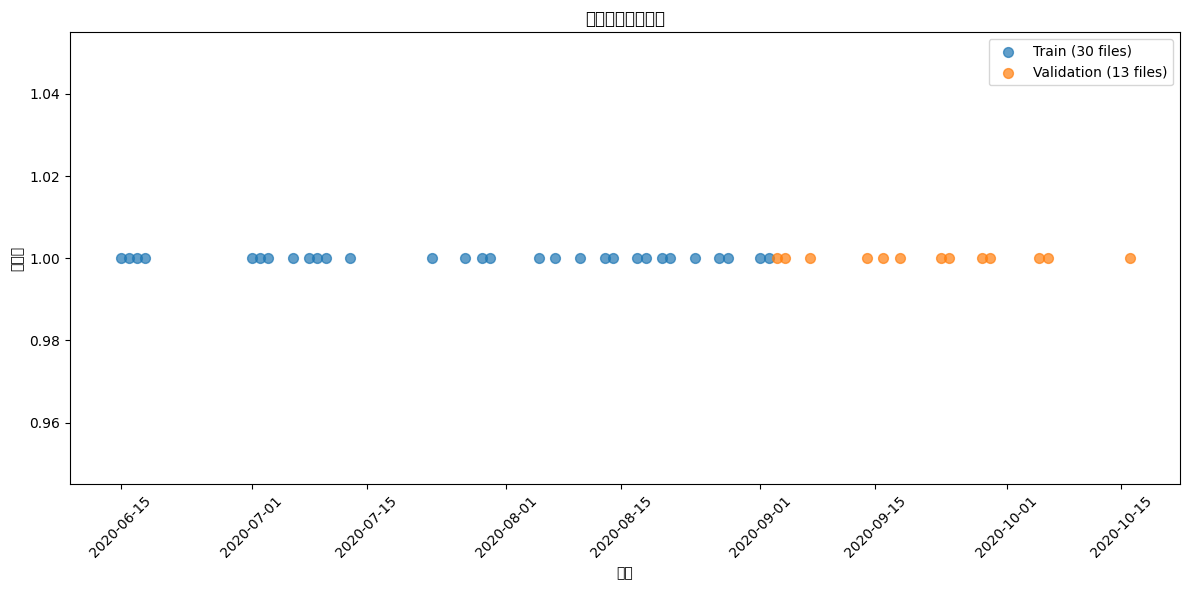

In [4]:
# === 策略 1: 時間序列切分實作 ===

def time_series_split(train_ratio=0.7, validation_ratio=0.3):
    """
    按時間順序切分資料
    train_ratio: 訓練集比例
    validation_ratio: 驗證集比例
    """
    
    # 依據檔案日期排序
    files_with_dates = []
    for _, row in files_df.iterrows():
        try:
            # 從檔名提取日期 (格式: _20200615_...)
            date_str = row['file_name'].split('_')[1]
            date = pd.to_datetime(date_str, format='%Y%m%d')
            files_with_dates.append((date, row['file_path'], row['file_name']))
        except:
            print(f"無法解析日期: {row['file_name']}")
    
    # 按日期排序
    files_with_dates.sort(key=lambda x: x[0])
    
    # 計算切分點
    total_files = len(files_with_dates)
    train_split = int(total_files * train_ratio)
    
    train_files_list = [f[1] for f in files_with_dates[:train_split]]
    val_files_list = [f[1] for f in files_with_dates[train_split:]]
    
    print(f"=== 時間序列切分結果 ===")
    print(f"總檔案數: {total_files}")
    print(f"訓練檔案數: {len(train_files_list)} ({len(train_files_list)/total_files*100:.1f}%)")
    print(f"驗證檔案數: {len(val_files_list)} ({len(val_files_list)/total_files*100:.1f}%)")
    
    # 顯示時間範圍
    if files_with_dates:
        train_start = files_with_dates[0][0].strftime('%Y-%m-%d')
        train_end = files_with_dates[train_split-1][0].strftime('%Y-%m-%d')
        val_start = files_with_dates[train_split][0].strftime('%Y-%m-%d')
        val_end = files_with_dates[-1][0].strftime('%Y-%m-%d')
        
        print(f"\n訓練期間: {train_start} ~ {train_end}")
        print(f"驗證期間: {val_start} ~ {val_end}")
    
    return train_files_list, val_files_list

# 執行時間序列切分
train_files_time, val_files_time = time_series_split()

# 視覺化時間分布
dates = []
split_types = []
for _, row in files_df.iterrows():
    try:
        date_str = row['file_name'].split('_')[1]
        date = pd.to_datetime(date_str, format='%Y%m%d')
        dates.append(date)
        if row['file_path'] in train_files_time:
            split_types.append('Train')
        else:
            split_types.append('Validation')
    except:
        continue

# 繪製時間分布圖
plt.figure(figsize=(12, 6))
df_plot = pd.DataFrame({'date': dates, 'split': split_types})
for split_type in ['Train', 'Validation']:
    subset = df_plot[df_plot['split'] == split_type]
    plt.scatter(subset['date'], [1]*len(subset), 
               label=f'{split_type} ({len(subset)} files)', 
               alpha=0.7, s=50)

plt.xlabel('日期')
plt.ylabel('資料集')
plt.title('時間序列切分分布')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 📁 策略 2: 檔案級別切分 (File-based Split)

**適用場景**: 確保同一檔案的資料不會同時出現在訓練和驗證集

**優點**:
- 避免同檔案資料洩漏
- 更真實的泛化評估
- 適合不同加工條件的評估

**缺點**:
- 需要足夠的檔案數量
- 可能有加工條件分布不均的問題

In [5]:
# === 策略 2: 檔案級別切分實作 ===

def file_based_split(test_size=0.3, random_state=42):
    """
    隨機選擇檔案進行切分
    test_size: 驗證集比例
    random_state: 隨機種子
    """
    
    # 獲取所有檔案路徑
    all_files = files_df['file_path'].tolist()
    
    # 隨機切分檔案
    train_files_list, val_files_list = train_test_split(
        all_files, 
        test_size=test_size, 
        random_state=random_state
    )
    
    print(f"=== 檔案級別切分結果 ===")
    print(f"總檔案數: {len(all_files)}")
    print(f"訓練檔案數: {len(train_files_list)} ({len(train_files_list)/len(all_files)*100:.1f}%)")
    print(f"驗證檔案數: {len(val_files_list)} ({len(val_files_list)/len(all_files)*100:.1f}%)")
    
    return train_files_list, val_files_list

def stratified_file_split(test_size=0.3, random_state=42):
    """
    依據加工條件進行分層切分
    """
    
    # 提取轉速資訊作為分層依據
    files_with_rpm = []
    files_without_rpm = []
    
    for _, row in files_df.iterrows():
        if pd.notna(row.get('rpm_info')):
            files_with_rpm.append((row['file_path'], row['rpm_info']))
        else:
            files_without_rpm.append(row['file_path'])
    
    print(f"有轉速資訊檔案: {len(files_with_rpm)}")
    print(f"無轉速資訊檔案: {len(files_without_rpm)}")
    
    train_files_list = []
    val_files_list = []
    
    # 對有轉速資訊的檔案進行分層切分
    if files_with_rpm:
        files_paths = [f[0] for f in files_with_rpm]
        rpm_labels = [f[1] for f in files_with_rpm]
        
        # 獲取唯一的轉速類別
        unique_rpms = list(set(rpm_labels))
        print(f"轉速類別: {unique_rpms}")
        
        try:
            train_rpm, val_rpm = train_test_split(
                files_paths, 
                test_size=test_size, 
                stratify=rpm_labels,
                random_state=random_state
            )
            train_files_list.extend(train_rpm)
            val_files_list.extend(val_rpm)
        except ValueError:
            # 如果無法分層，使用普通切分
            print("無法進行分層切分，使用隨機切分")
            train_rpm, val_rpm = train_test_split(
                files_paths, 
                test_size=test_size, 
                random_state=random_state
            )
            train_files_list.extend(train_rpm)
            val_files_list.extend(val_rpm)
    
    # 對無轉速資訊的檔案進行隨機切分
    if files_without_rpm:
        train_other, val_other = train_test_split(
            files_without_rpm, 
            test_size=test_size, 
            random_state=random_state
        )
        train_files_list.extend(train_other)
        val_files_list.extend(val_other)
    
    print(f"\n=== 分層檔案切分結果 ===")
    print(f"訓練檔案數: {len(train_files_list)}")
    print(f"驗證檔案數: {len(val_files_list)}")
    
    return train_files_list, val_files_list

# 執行兩種檔案切分方法
print("=== 方法 2a: 隨機檔案切分 ===")
train_files_random, val_files_random = file_based_split()

print("\n=== 方法 2b: 分層檔案切分 ===")
train_files_stratified, val_files_stratified = stratified_file_split()

=== 方法 2a: 隨機檔案切分 ===
=== 檔案級別切分結果 ===
總檔案數: 43
訓練檔案數: 30 (69.8%)
驗證檔案數: 13 (30.2%)

=== 方法 2b: 分層檔案切分 ===
有轉速資訊檔案: 41
無轉速資訊檔案: 2
轉速類別: ['1000rpm', '2krpm', '1k+2krpm', '2k+1krpm', '1krpm', '2000rpm']

=== 分層檔案切分結果 ===
訓練檔案數: 29
驗證檔案數: 14


## 🏆 策略 3: 競賽規則切分 (Competition-aligned Split)

**適用場景**: 完全符合競賽評估規則，前100行用於訓練，第101+行用於驗證

**優點**:
- 與競賽評估完全一致
- 充分利用所有資料
- 真實反映競賽表現

**缺點**:
- 可能存在時間序列洩漏
- 驗證結果可能過於樂觀

=== 競賽規則切分結果 ===
處理檔案數: 43
訓練樣本數: 4,300
驗證樣本數: 25,495
平均每檔訓練行數: 100
平均每檔驗證行數: 593
包含目標變數檔案: 43/43


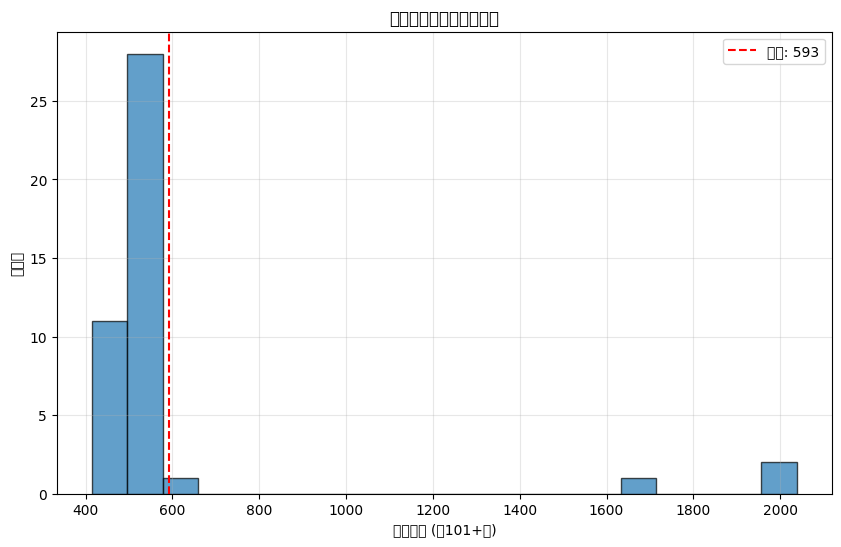


=== 資料特徵摘要 ===
訓練集特徵數: 27
驗證集特徵數: 27
共同特徵數: 27
✅ 目標變數 ['Disp. X', 'Disp. Z'] 在訓練和驗證集中都存在

前5個共同特徵: ['PT07', 'TC06', 'PT09', 'PT13', 'TC04']


In [6]:
# === 策略 3: 競賽規則切分實作 ===

def competition_split():
    """
    依據競賽規則切分：每個檔案前100行訓練，第101+行驗證
    """
    
    train_data = []
    val_data = []
    split_stats = []
    
    for file_path in train_files:
        file_name = os.path.basename(file_path)
        df = pd.read_csv(file_path, low_memory=False)
        
        if len(df) <= 100:
            print(f"⚠️ 檔案行數不足: {file_name} ({len(df)} 行)")
            continue
            
        # 前100行作為訓練
        train_part = df.iloc[:100].copy()
        train_part['__file__'] = file_name
        train_part['__split__'] = 'train'
        train_data.append(train_part)
        
        # 第101+行作為驗證
        val_part = df.iloc[100:].copy()
        val_part['__file__'] = file_name
        val_part['__split__'] = 'val'
        val_data.append(val_part)
        
        # 統計資訊
        split_stats.append({
            'file_name': file_name,
            'total_rows': len(df),
            'train_rows': 100,
            'val_rows': len(df) - 100,
            'has_targets': all(t in df.columns for t in TARGETS)
        })
    
    # 合併資料
    train_combined = pd.concat(train_data, ignore_index=True) if train_data else pd.DataFrame()
    val_combined = pd.concat(val_data, ignore_index=True) if val_data else pd.DataFrame()
    
    print(f"=== 競賽規則切分結果 ===")
    print(f"處理檔案數: {len(split_stats)}")
    print(f"訓練樣本數: {len(train_combined):,}")
    print(f"驗證樣本數: {len(val_combined):,}")
    
    if split_stats:
        stats_df = pd.DataFrame(split_stats)
        print(f"平均每檔訓練行數: {stats_df['train_rows'].mean():.0f}")
        print(f"平均每檔驗證行數: {stats_df['val_rows'].mean():.0f}")
        print(f"包含目標變數檔案: {stats_df['has_targets'].sum()}/{len(stats_df)}")
        
        # 顯示驗證行數分布
        plt.figure(figsize=(10, 6))
        plt.hist(stats_df['val_rows'], bins=20, alpha=0.7, edgecolor='black')
        plt.xlabel('驗證行數 (第101+行)')
        plt.ylabel('檔案數')
        plt.title('各檔案驗證資料行數分布')
        plt.axvline(stats_df['val_rows'].mean(), color='red', linestyle='--', 
                   label=f'平均: {stats_df["val_rows"].mean():.0f}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    return train_combined, val_combined, stats_df

# 執行競賽規則切分
train_competition, val_competition, competition_stats = competition_split()

# 顯示結果摘要
if not train_competition.empty and not val_competition.empty:
    print(f"\n=== 資料特徵摘要 ===")
    
    # 檢查特徵一致性
    train_features = set(train_competition.columns) - {'__file__', '__split__'}
    val_features = set(val_competition.columns) - {'__file__', '__split__'}
    common_features = train_features & val_features
    
    print(f"訓練集特徵數: {len(train_features)}")
    print(f"驗證集特徵數: {len(val_features)}")
    print(f"共同特徵數: {len(common_features)}")
    
    # 目標變數檢查
    if all(t in common_features for t in TARGETS):
        print(f"✅ 目標變數 {TARGETS} 在訓練和驗證集中都存在")
    else:
        print(f"❌ 目標變數缺失")
        
    print(f"\n前5個共同特徵: {list(common_features)[:5]}")
else:
    print("❌ 切分失敗，無法生成訓練或驗證資料")

## 🔄 策略 4: 交叉驗證方法 (Cross-Validation)

**適用場景**: 充分利用所有資料，獲得更穩定的模型評估

**可選方法**:
1. **GroupKFold**: 以檔案為組，確保同檔案不跨fold
2. **TimeSeriesSplit**: 時間序列交叉驗證
3. **StratifiedKFold**: 分層交叉驗證 (基於加工條件)

In [7]:
# === 策略 4: 交叉驗證方法實作 ===

def setup_cross_validation(n_splits=5):
    """
    設定多種交叉驗證方法
    """
    
    # 準備檔案級別的群組資料
    file_groups = []
    file_list = []
    
    for _, row in files_df.iterrows():
        file_list.append(row['file_path'])
        file_groups.append(row['file_name'])  # 以檔名作為群組
    
    print(f"=== 交叉驗證設定 ===")
    print(f"總檔案數: {len(file_list)}")
    print(f"Fold 數: {n_splits}")
    
    # 1. GroupKFold - 以檔案為群組
    group_kfold = GroupKFold(n_splits=n_splits)
    group_splits = list(group_kfold.split(file_list, groups=file_groups))
    
    print(f"\n=== GroupKFold (檔案級別) ===")
    for i, (train_idx, val_idx) in enumerate(group_splits):
        train_files_fold = [file_list[j] for j in train_idx]
        val_files_fold = [file_list[j] for j in val_idx]
        print(f"Fold {i+1}: Train={len(train_files_fold)}, Val={len(val_files_fold)}")
    
    # 2. 時間序列交叉驗證準備
    # 先按日期排序檔案
    files_with_dates = []
    for file_path in file_list:
        file_name = os.path.basename(file_path)
        try:
            date_str = file_name.split('_')[1]
            date = pd.to_datetime(date_str, format='%Y%m%d')
            files_with_dates.append((date, file_path))
        except:
            # 如果無法解析日期，使用檔名順序
            files_with_dates.append((pd.Timestamp('1900-01-01'), file_path))
    
    files_with_dates.sort(key=lambda x: x[0])
    sorted_files = [f[1] for f in files_with_dates]
    
    # TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)
    ts_splits = list(tscv.split(sorted_files))
    
    print(f"\n=== TimeSeriesSplit (時間序列) ===")
    for i, (train_idx, val_idx) in enumerate(ts_splits):
        train_files_fold = [sorted_files[j] for j in train_idx]
        val_files_fold = [sorted_files[j] for j in val_idx]
        print(f"Fold {i+1}: Train={len(train_files_fold)}, Val={len(val_files_fold)}")
        
        # 顯示時間範圍
        if files_with_dates:
            try:
                train_dates = [files_with_dates[j][0] for j in train_idx]
                val_dates = [files_with_dates[j][0] for j in val_idx]
                print(f"  Train期間: {min(train_dates).strftime('%Y-%m-%d')} ~ {max(train_dates).strftime('%Y-%m-%d')}")
                print(f"  Val期間: {min(val_dates).strftime('%Y-%m-%d')} ~ {max(val_dates).strftime('%Y-%m-%d')}")
            except:
                pass
    
    return {
        'group_kfold': group_splits,
        'time_series': ts_splits,
        'file_list': file_list,
        'sorted_files': sorted_files,
        'file_groups': file_groups
    }

def evaluate_split_quality(train_files_list, val_files_list, split_name):
    """
    評估切分品質
    """
    
    print(f"\n=== {split_name} 切分品質評估 ===")
    
    # 載入並分析訓練/驗證資料
    train_stats = {'total_rows': 0, 'files': 0, 'conditions': set()}
    val_stats = {'total_rows': 0, 'files': 0, 'conditions': set()}
    
    for file_path in train_files_list:
        df = pd.read_csv(file_path, low_memory=False)
        train_stats['total_rows'] += len(df)
        train_stats['files'] += 1
        
        # 提取加工條件
        file_name = os.path.basename(file_path)
        if 'rpm' in file_name.lower():
            rpm_info = [p for p in file_name.split('_') if 'rpm' in p.lower()]
            if rpm_info:
                train_stats['conditions'].add(rpm_info[0])
    
    for file_path in val_files_list:
        df = pd.read_csv(file_path, low_memory=False)
        val_stats['total_rows'] += len(df)
        val_stats['files'] += 1
        
        # 提取加工條件
        file_name = os.path.basename(file_path)
        if 'rpm' in file_name.lower():
            rpm_info = [p for p in file_name.split('_') if 'rpm' in p.lower()]
            if rpm_info:
                val_stats['conditions'].add(rpm_info[0])
    
    print(f"訓練集: {train_stats['files']} 檔案, {train_stats['total_rows']:,} 行")
    print(f"驗證集: {val_stats['files']} 檔案, {val_stats['total_rows']:,} 行")
    print(f"訓練集條件: {len(train_stats['conditions'])} 種")
    print(f"驗證集條件: {len(val_stats['conditions'])} 種")
    print(f"共同條件: {len(train_stats['conditions'] & val_stats['conditions'])} 種")
    
    # 條件分布平衡性
    overlap_ratio = len(train_stats['conditions'] & val_stats['conditions']) / max(len(train_stats['conditions']), len(val_stats['conditions']), 1)
    print(f"條件重疊率: {overlap_ratio:.2%}")
    
    return {
        'train_stats': train_stats,
        'val_stats': val_stats,
        'overlap_ratio': overlap_ratio
    }

# 執行交叉驗證設定
cv_setup = setup_cross_validation()

# 評估不同切分方法的品質
print("\n" + "="*50)
print("各切分方法品質比較")
print("="*50)

evaluate_split_quality(train_files_time, val_files_time, "時間序列切分")
evaluate_split_quality(train_files_random, val_files_random, "隨機檔案切分")
evaluate_split_quality(train_files_stratified, val_files_stratified, "分層檔案切分")

=== 交叉驗證設定 ===
總檔案數: 43
Fold 數: 5

=== GroupKFold (檔案級別) ===
Fold 1: Train=34, Val=9
Fold 2: Train=34, Val=9
Fold 3: Train=34, Val=9
Fold 4: Train=35, Val=8
Fold 5: Train=35, Val=8

=== TimeSeriesSplit (時間序列) ===
Fold 1: Train=8, Val=7
  Train期間: 2020-06-15 ~ 2020-07-06
  Val期間: 2020-07-08 ~ 2020-07-29
Fold 2: Train=15, Val=7
  Train期間: 2020-06-15 ~ 2020-07-29
  Val期間: 2020-07-30 ~ 2020-08-17
Fold 3: Train=22, Val=7
  Train期間: 2020-06-15 ~ 2020-08-17
  Val期間: 2020-08-18 ~ 2020-09-01
Fold 4: Train=29, Val=7
  Train期間: 2020-06-15 ~ 2020-09-01
  Val期間: 2020-09-02 ~ 2020-09-18
Fold 5: Train=36, Val=7
  Train期間: 2020-06-15 ~ 2020-09-18
  Val期間: 2020-09-23 ~ 2020-10-16

各切分方法品質比較

=== 時間序列切分 切分品質評估 ===
訓練集: 30 檔案, 20,511 行
驗證集: 13 檔案, 9,284 行
訓練集條件: 4 種
驗證集條件: 5 種
共同條件: 3 種
條件重疊率: 60.00%

=== 隨機檔案切分 切分品質評估 ===
訓練集: 30 檔案, 22,118 行
驗證集: 13 檔案, 7,677 行
訓練集條件: 6 種
驗證集條件: 6 種
共同條件: 6 種
條件重疊率: 100.00%

=== 分層檔案切分 切分品質評估 ===
訓練集: 29 檔案, 20,049 行
驗證集: 14 檔案, 9,746 行
訓練集條件: 6 種
驗證集條件: 6 種
共同條件: 6 種


{'train_stats': {'total_rows': 20049,
  'files': 29,
  'conditions': {'1000rpm',
   '1k+2krpm',
   '1krpm',
   '2000rpm',
   '2k+1krpm',
   '2krpm'}},
 'val_stats': {'total_rows': 9746,
  'files': 14,
  'conditions': {'1000rpm',
   '1k+2krpm',
   '1krpm',
   '2000rpm',
   '2k+1krpm',
   '2krpm'}},
 'overlap_ratio': 1.0}

## 💾 切分結果儲存與使用建議

根據不同需求選擇合適的切分策略：

### 🎯 建議選擇指南

1. **🏆 競賽提交**: 使用 **競賽規則切分** (策略3)
   - 與競賽評估完全一致
   - 最能反映真實提交分數

2. **🔬 模型開發**: 使用 **檔案級別切分** (策略2) 
   - 避免資料洩漏
   - 更真實的泛化能力評估

3. **⏰ 時序預測**: 使用 **時間序列切分** (策略1)
   - 符合時間順序
   - 適合部署情境

4. **🔄 穩定評估**: 使用 **交叉驗證** (策略4)
   - 充分利用資料
   - 獲得更穩定的評估結果

In [8]:
# === 儲存切分結果 ===

def save_split_results():
    """
    儲存各種切分結果為 JSON 檔案，方便後續使用
    """
    
    import json
    from datetime import datetime
    
    # 建立輸出目錄
    split_output_dir = Path(OUTPUT_BASE) / "data_splits"
    split_output_dir.mkdir(exist_ok=True)
    
    # 準備儲存的切分結果
    split_results = {
        'created_at': datetime.now().isoformat(),
        'total_files': len(train_files),
        'splits': {
            'time_series': {
                'description': '時間序列切分 (70% train, 30% val)',
                'train_files': [os.path.basename(f) for f in train_files_time],
                'val_files': [os.path.basename(f) for f in val_files_time]
            },
            'random_files': {
                'description': '隨機檔案切分 (70% train, 30% val)',
                'train_files': [os.path.basename(f) for f in train_files_random],
                'val_files': [os.path.basename(f) for f in val_files_random]
            },
            'stratified_files': {
                'description': '分層檔案切分 (依轉速分層)',
                'train_files': [os.path.basename(f) for f in train_files_stratified],
                'val_files': [os.path.basename(f) for f in val_files_stratified]
            },
            'competition_aligned': {
                'description': '競賽規則切分 (前100行 train, 101+行 val)',
                'method': 'within_file_split',
                'train_rows_per_file': 100,
                'files_processed': len(competition_stats) if 'competition_stats' in locals() else 0
            }
        }
    }
    
    # 儲存為 JSON
    output_file = split_output_dir / f"split_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(split_results, f, ensure_ascii=False, indent=2)
    
    print(f"✅ 切分結果已儲存至: {output_file}")
    
    # 也儲存一個最新版本
    latest_file = split_output_dir / "latest_splits.json"
    with open(latest_file, 'w', encoding='utf-8') as f:
        json.dump(split_results, f, ensure_ascii=False, indent=2)
    
    print(f"✅ 最新切分結果: {latest_file}")
    
    return output_file

def load_split_results(file_path=None):
    """
    載入之前儲存的切分結果
    """
    
    if file_path is None:
        split_output_dir = Path(OUTPUT_BASE) / "data_splits"
        file_path = split_output_dir / "latest_splits.json"
    
    if not Path(file_path).exists():
        print(f"❌ 切分結果檔案不存在: {file_path}")
        return None
    
    with open(file_path, 'r', encoding='utf-8') as f:
        split_results = json.load(f)
    
    print(f"✅ 載入切分結果: {file_path}")
    print(f"建立時間: {split_results['created_at']}")
    print(f"總檔案數: {split_results['total_files']}")
    
    return split_results

def create_train_val_datasets(strategy='competition_aligned'):
    """
    根據選擇的策略建立訓練和驗證資料集
    """
    
    if strategy == 'competition_aligned':
        if 'train_competition' in locals() and 'val_competition' in locals():
            return train_competition, val_competition
        else:
            print("❌ 請先執行競賽規則切分")
            return None, None
            
    elif strategy == 'time_series':
        # 載入時間序列切分的檔案並合併
        train_data = []
        val_data = []
        
        for file_path in train_files_time:
            df = pd.read_csv(file_path, low_memory=False)
            df['__file__'] = os.path.basename(file_path)
            train_data.append(df)
            
        for file_path in val_files_time:
            df = pd.read_csv(file_path, low_memory=False)
            df['__file__'] = os.path.basename(file_path)
            val_data.append(df)
            
        train_combined = pd.concat(train_data, ignore_index=True)
        val_combined = pd.concat(val_data, ignore_index=True)
        
        return train_combined, val_combined
        
    else:
        print(f"❌ 不支援的策略: {strategy}")
        return None, None

# 儲存切分結果
if 'train_files_time' in locals():
    saved_file = save_split_results()
    
    # 示範如何使用
    print(f"\n=== 使用範例 ===")
    print("# 載入切分結果")
    print("split_data = load_split_results()")
    print("")
    print("# 建立訓練/驗證資料集")
    print("train_df, val_df = create_train_val_datasets('competition_aligned')")
    print("# 或")
    print("train_df, val_df = create_train_val_datasets('time_series')")
else:
    print("❌ 請先執行前面的切分程式碼")

✅ 切分結果已儲存至: /Users/benjamin/1132/11325/AI_Race/data_splits/split_results_20250817_175444.json
✅ 最新切分結果: /Users/benjamin/1132/11325/AI_Race/data_splits/latest_splits.json

=== 使用範例 ===
# 載入切分結果
split_data = load_split_results()

# 建立訓練/驗證資料集
train_df, val_df = create_train_val_datasets('competition_aligned')
# 或
train_df, val_df = create_train_val_datasets('time_series')


## 📋 總結與最佳實踐

### 🎯 針對不同階段的建議

#### 🔍 **探索階段**
- 使用 **競賽規則切分** 快速評估模型
- 觀察 RMSE 與 learn.ipynb 的結果是否一致

#### 🛠️ **開發階段** 
- 使用 **檔案級別切分** 或 **時間序列切分**
- 避免過度擬合和資料洩漏
- 使用交叉驗證確保模型穩定性

#### 🏆 **競賽階段**
- 主要依據 **競賽規則切分** 的結果
- 參考其他切分方法的一致性
- 選擇在各種切分下都表現穩定的模型

### ⚠️ **常見陷阱**

1. **時間洩漏**: 使用未來資訊預測過去
2. **檔案洩漏**: 同檔案資料出現在訓練和驗證集
3. **分布偏移**: 訓練和驗證集的加工條件分布差異
4. **過度樂觀**: 僅使用競賽切分可能高估模型性能

### 🔧 **實用技巧**

1. **多重驗證**: 使用多種切分方法驗證模型穩定性
2. **條件平衡**: 確保不同加工條件在訓練/驗證集中均勻分布
3. **時間感知**: 考慮加工順序對預測的影響
4. **檔案完整性**: 檢查所有檔案是否包含完整的特徵和目標變數

### 📊 **評估指標建議**

- **主要指標**: RMSE (符合競賽要求)
- **輔助指標**: MAE、R²、方向準確度
- **穩定性**: 交叉驗證標準差
- **泛化能力**: 不同切分方法的一致性

---

**🎉 恭喜！你現在掌握了完整的資料切分策略。**

**下一步**: 在 `learn.ipynb` 中套用這些切分方法來訓練和評估模型。